In [86]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import geocoder
import folium
from geopy.geocoders import Nominatim # convert an address to langtitude and longitude
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# import k-means from clustering stage
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import matplotlib.colors as colors
import  matplotlib.pyplot as plt
import math
import seaborn as sns

# Introduction

My company want to open the new coffee shop brand in Ho Chi Minh City, Vietnam. We need to analyze coffee shop market in Ho Chi Minh City.


---
### Our target:
    1. Find the best place (district/ward) to open a new coffee shop in HCMC.
    2. Analyze the coffee shop market in HCMC base on data been collected.
---

### Analytic Approach

---

    1. We are using cluster analysis to segment each district.
    2. Using data visualization to understand our data.

---


### Data Requirements and Data Collections

---
#### Data Requirements
    1. Using tabular data from foursquare database and other source including wikipedia and government official website.


---




#### Data Collections
1. Collect district data includes : (Population,Acreage) using beautifulsoup list on
   [Wikipedia](https://vi.wikipedia.org/wiki/Th%C3%A0nh_ph%E1%BB%91_H%E1%BB%93_Ch%C3%AD_Minh).
   ![alt text](./District_wiki.png) <br />
   
2. Collection ward data  includes : (Province/City Code,District Code,District Name,Ward Code,Ward Name).
3. Using google map collect Latitude and Longitude for each ward in HCMC.
4. Using foursquare API collect location data for each ward in HCMC.

# Data Collection Step

#### Collect district data (District Name,Population,Acreage).Scraping data on wikipedia website

In [2]:
url = "https://vi.wikipedia.org/wiki/Th%C3%A0nh_ph%E1%BB%91_H%E1%BB%93_Ch%C3%AD_Minh"

r  = requests.get(url)

data = r.text

soup = BeautifulSoup(data,'lxml')

In [4]:
df = []
for i in soup.find_all("table",class_="wikitable sortable")[0].find_all("tr"):
    ls = []
    for j in i.find_all("td"):
        ls.append(j.get_text())
    df.append(ls)
df = pd.DataFrame(df)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,\n\n\nTên\n\nDiện tích (km²)\nDân số (người)\n...,Quận (19)\n,Quận 1\n,"7,72",142.000,10 phường\n,Quận 2\n,"49,79",180.000,11 phường\n,...,"1 thị trấn, 20 xã\n",Hóc Môn\n,"109,17",542.000,"1 thị trấn, 11 xã\n",Nhà Bè\n,"100,43",206.000,"1 thị trấn, 6 xã\n",\n
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Quận (19)\n,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Quận 1\n,"7,72",142.000,10 phường\n,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [6]:
# List of District_code include : district name, district code
District_code = {'Quận 1':760,
                 'Quận 2':769,
                 'Quận 3':770,
                 'Quận 4':773,
                 'Quận 5':774,
                 'Quận 6':775,
                 'Quận 7':778,
                 'Quận 8':776,
                 'Quận 9':763,
                 'Quận 10':771,
                 'Quận 11':772,
                 'Quận 12':761,
                 'Bình Tân':777,
                 'Bình Thạnh':765,
                 'Gò Vấp':764,
                 'Phú Nhuận':768,
                 'Tân Bình':766,
                 'Tân Phú':767,
                 'Thủ Đức':762,
                 'Bình Chánh':785,
                 'Cần Giờ':787,
                 'Củ Chi':783,
                 'Hóc Môn':784,
                 'Nhà Bè':786,
                }

#### Cleaning, repairing dataframe for district list

In [7]:
df.drop(labels=[0,1,2,3,16,24],inplace=True)
df = df.iloc[:,0:3]
df.columns=['District Name','Acreage (Km2)','Population']
df.reset_index(drop=True,inplace=True)
# Remove EOL "\n" String in dataset
for i in df.columns:
    df[i] = df[i].str.replace("\n","",regex=True)
# Add an District Code columns to verify district
df['District Code'] = df['District Name'].map(lambda x:District_code[x])
# Change columns order ['District Code','District Name','Acreage (Km2)','Population']
df = df[['District Code','District Name','Acreage (Km2)','Population']]

In [8]:
# change 'Acreage (Km2)' column and 'Population' to float and int
df['Acreage (Km2)'] = df['Acreage (Km2)'].str.replace(",",".",regex=True)
df['Population'] = df['Population'].str.replace(".","",regex=True)
df['Acreage (Km2)'].astype(float)
df['Population'].astype(int)

0     142000
1     180000
2     190000
3     175000
4     159000
5     233000
6     360000
7     424000
8     397000
9     234000
10    209000
11    620000
12    784000
13    499000
14    676000
15    163000
16    474000
17    485000
18    592000
19    705000
20     71000
21    462000
22    542000
23    206000
Name: Population, dtype: int32

In [9]:
df.head()

,District Code,District Name,Acreage (Km2),Population
0,760,Quận 1,7.72,142000
1,769,Quận 2,49.79,180000
2,770,Quận 3,4.92,190000
3,773,Quận 4,4.18,175000
4,774,Quận 5,4.27,159000


In [10]:
df.shape

(24, 4)

**We have 24 district in HCMC with 4 columns in our dataframe**

In [1]:
# create df_hcmc as a copy for this step
df_hcmc = df.copy()

NameError: name 'df' is not defined

### Prepair ward dataframe in HCMC using csv file collected from other source

In [12]:
# reading ward dataframe
df_hcm_cor = pd.read_csv("HCM district and ward coordinates complete.csv")

In [13]:
df_hcm_cor.head()

,Unnamed: 0,Ward Code,Ward Name,District Code,District Name,Province/City Code,Province/City Name,Latitude,Longitude
0,0,26734,Phường Tân Định,760,Quận 1,79,Thành phố Hồ Chí Minh,"10,792645","106,690645"
1,1,26737,Phường Đa Kao,760,Quận 1,79,Thành phố Hồ Chí Minh,"10,789305","106,698753"
2,2,26740,Phường Bến Nghé,760,Quận 1,79,Thành phố Hồ Chí Minh,"10,780322","106,704141"
3,3,26743,Phường Bến Thành,760,Quận 1,79,Thành phố Hồ Chí Minh,"10,774806","106,495684"
4,4,26746,Phường Nguyễn Thái Bình,760,Quận 1,79,Thành phố Hồ Chí Minh,"10,768872","106,701093"


In [14]:
df_hcm_cor.shape

(322, 9)

**There are 322 wards in HCMC**

#### Merge 2 dataframe by add Acreage (Km2)	columns and Population columns into df_hcm_cor dataframe

In [15]:
# merge 2 dataframe. add 2 columns: Acreage (Km2) column and Population column
df_hcm_cor['Acreage (Km2)'] = df_hcm_cor['District Code'].map(lambda x:df[df['District Code']==x].iloc[0,2])
df_hcm_cor['Population'] = df_hcm_cor['District Code'].map(lambda x:df[df['District Code']==x].iloc[0,3])

In [16]:
df_hcm_cor.head()

,Unnamed: 0,Ward Code,Ward Name,District Code,District Name,Province/City Code,Province/City Name,Latitude,Longitude,Acreage (Km2),Population
0,0,26734,Phường Tân Định,760,Quận 1,79,Thành phố Hồ Chí Minh,"10,792645","106,690645",7.72,142000
1,1,26737,Phường Đa Kao,760,Quận 1,79,Thành phố Hồ Chí Minh,"10,789305","106,698753",7.72,142000
2,2,26740,Phường Bến Nghé,760,Quận 1,79,Thành phố Hồ Chí Minh,"10,780322","106,704141",7.72,142000
3,3,26743,Phường Bến Thành,760,Quận 1,79,Thành phố Hồ Chí Minh,"10,774806","106,495684",7.72,142000
4,4,26746,Phường Nguyễn Thái Bình,760,Quận 1,79,Thành phố Hồ Chí Minh,"10,768872","106,701093",7.72,142000


In [17]:
# change Latitude and Longtitude in to float type
df_hcm_cor['Latitude'] = df_hcm_cor['Latitude'].str.replace(",",".",regex=True)
df_hcm_cor['Longitude'] = df_hcm_cor['Longitude'].str.replace(",",".",regex=True)
df_hcm_cor['Latitude'].astype(float)
df_hcm_cor['Longitude'].astype(float)

0      106.690645
1      106.698753
2      106.704141
3      106.495684
4      106.701093
          ...    
317    106.889738
318    106.811632
319    106.978980
320    106.900317
321    106.806568
Name: Longitude, Length: 322, dtype: float64

In [18]:
# remove unnecessary columns
df_hcm_cor = df_hcm_cor.iloc[:,1:]

In [19]:
df_hcm_cor.head()

,Ward Code,Ward Name,District Code,District Name,Province/City Code,Province/City Name,Latitude,Longitude,Acreage (Km2),Population
0,26734,Phường Tân Định,760,Quận 1,79,Thành phố Hồ Chí Minh,10.792645,106.690645,7.72,142000
1,26737,Phường Đa Kao,760,Quận 1,79,Thành phố Hồ Chí Minh,10.789305,106.698753,7.72,142000
2,26740,Phường Bến Nghé,760,Quận 1,79,Thành phố Hồ Chí Minh,10.780322,106.704141,7.72,142000
3,26743,Phường Bến Thành,760,Quận 1,79,Thành phố Hồ Chí Minh,10.774806,106.495684,7.72,142000
4,26746,Phường Nguyễn Thái Bình,760,Quận 1,79,Thành phố Hồ Chí Minh,10.768872,106.701093,7.72,142000


### Visualize data on HCMC map using folium

In [20]:
# get hcmc coordinate
address = 'Ho Chi Minh'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Ho Chi Minh City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Ho Chi Minh City are 10.7758439, 106.7017555.


In [21]:
# create list of color display on folium map
color_label = sns.color_palette("muted", n_colors=30)
color_label = color_label.as_hex()
j = 0
colors = dict()
for i in df_hcm_cor['District Name'].unique():
    colors[i] = color_label[j]
    j = j + 1

In [22]:
# visually all ward in HCMC
m = folium.Map(location=[latitude, longitude],zoom_start=12)
#url = 'https://cocl.us/sanfran_geojson'
#geo_data_input = f'{url}'
for index,values in df_hcm_cor.iterrows():
    folium.CircleMarker(
        [values['Latitude'], values['Longitude']],
        radius=3,
        color=colors[values['District Name']],
        fill=True,
        fill_color=0.8392156862745098,#colors[values['District Name']],
        fill_opacity=0.7,
        parse_html=False).add_to(m)  
    
# Add lengend by using html for folium map
#legend_html = '''
#     <div style="position: fixed; 
#     bottom: 50px; right: 50px; width: 100px; height: 90px; 
#     border:2px solid grey; z-index:9999; font-size:14px;
#     ">&nbsp; Cool Legend <br>
#     &nbsp; East &nbsp; <i class="leaflet-interactive"
#                  style=”color:green”></i><br>
#     &nbsp; West &nbsp; <i class="leaflet-interactive"
#                  style=”color:red”></i>
#      </div>
#     '''
#m.get_root().html.add_child(folium.Element(legend_html))
m

In [23]:
CLIENT_ID = 'TYNGSEF0SNXTWZU5JEPMP3Z3BSCBA2TQEK2ODCGA114NG4GG' # your Foursquare ID
CLIENT_SECRET = 'G21UECLTFUK3MLIFP4SQK03OR1JMMDI4EPQS4J12TF0CFMP3' # your Foursquare Secret
VERSION = '20200310' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TYNGSEF0SNXTWZU5JEPMP3Z3BSCBA2TQEK2ODCGA114NG4GG
CLIENT_SECRET:G21UECLTFUK3MLIFP4SQK03OR1JMMDI4EPQS4J12TF0CFMP3


In [28]:
# getting json data from foursquare using API
def get_foursquare_url(cl_id,cl_se,ver,lat,long,radius,category):
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&intent=browse&limit=10000'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius,
        category,
        )
    return url

def getNearbyVenues(df_get,District_Code,names,population, latitudes, longitudes, acreage,category_type,category):
    CLIENT_ID = 'TYNGSEF0SNXTWZU5JEPMP3Z3BSCBA2TQEK2ODCGA114NG4GG' # your Foursquare ID
    CLIENT_SECRET = 'G21UECLTFUK3MLIFP4SQK03OR1JMMDI4EPQS4J12TF0CFMP3' # your Foursquare Secret
    VERSION = 20200304
    venues_list=[]
    for dis_id,name,pop, lat, lng,acr in zip(District Code,names,population, latitudes, longitudes, acreage):
        print(name)
            
        # create the API request URL
        url = get_foursquare_url(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,int(math.sqrt(float(acr)/float(3.14))*1000),category)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            dis_id,
            name,
            pop,
            acr,
            lat, 
            lng, 
            v['id'],
            v['name'],
            v['location']['lat'], 
            v['location']['lng'],
            category_type
        ) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District Id','District Name',
                  'District Population',
                  'District Acreage (Km2)',
                  'District Latitude', 
                  'District Longitude',
                  'Venue Id',
                  'Venue Name',
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                ]
    
    return(nearby_venues)

In [29]:
def getNearbyVenues(df_get,category_type,category):
    CLIENT_ID = 'TYNGSEF0SNXTWZU5JEPMP3Z3BSCBA2TQEK2ODCGA114NG4GG' # your Foursquare ID
    CLIENT_SECRET = 'G21UECLTFUK3MLIFP4SQK03OR1JMMDI4EPQS4J12TF0CFMP3' # your Foursquare Secret
    VERSION = 20200310
    venues_list=[]
    for index,value in df_get.iterrows():
        print(value['Ward Name'])
        
        # Lấy trung bình diện tích cho mỗi quận sau đó chia lấy radius cho tất cả các quận theo trung bình
        avg = float(value['Acreage (Km2)'])/df_get[df_get['District Code']==value['District Code']].shape[0]
        # create the API request URL
        url = get_foursquare_url(CLIENT_ID,CLIENT_SECRET,VERSION,value['Latitude'],value['Longitude'],int(math.sqrt(float(avg)/float(3.14))*1000),category)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            value['District Code'],
            value['District Name'],
            value['Ward Code'],
            value['Ward Name'],
            value['Population'],
            value['Acreage (Km2)'],
            value['Latitude'], 
            value['Longitude'], 
            v['id'],
            v['name'],
            v['location']['lat'], 
            v['location']['lng'],
            category_type
        ) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'District Code',
                  'District Name',
                  'Ward Code',
                  'Ward Name',
                  'District Population',
                  'District Acreage (Km2)',
                  'District Latitude', 
                  'District Longitude',
                  'Venue Id',
                  'Venue Name',
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                ]
    
    return(nearby_venues)

### Explain data detail
1. I will segment our data by 3 part: coffee venues, short term venues, long term venues
2. I will get all venues in our radius for each ward with a radius equal (District Acreage/Number of the ward in each district)
3. Short term venues includes: all kind of entertainment venues...
4. Long term venues included: department, industry zones, government department...
5. I decided to segment our data because those kinds of long term and short term venues could provide different types of customers for our coffee shop. One type is : the traveler, the non-resident customer. One type is : the regular customer...
3. I will define coffee_category,short_term_venues,long_term_venues on foursquare website.

In [26]:
# define coffee category and get coffee venues data from foursquare database
coffee_category = '4bf58dd8d48988d1e0931735,5665c7b9498e7d8a4f2c0f06,5e18993feee47d000759b256,4bf58dd8d48988d1a1941735,4bf58dd8d48988d128941735,4bf58dd8d48988d16d941735,54135bf5e4b08f3d2429dfe7,56aa371be4b08b9a8d573508,54f4ba06498e2cf5561da814,4bf58dd8d48988d18d941735,4bf58dd8d48988d1f0941735'
coffee_venues = getNearbyVenues(df_hcm_cor,category_type="Coffee Shop",category=coffee_category)

In [29]:
coffee_venues.head()

,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5cf5112d35811b002c10c030,Cộng Caphe - Nhà Thờ Tân Định,10.788813,106.690870,Coffee Shop
1,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5daad4eabe7d890007ce18a9,phúc long trần quang khải,10.792380,106.694436,Coffee Shop
2,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5e5242732609e60008c7ce84,Cafe Biệt Động,10.792224,106.688356,Coffee Shop
3,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5c42d51d3092be002c9eead6,Cheese Coffee,10.796439,106.690473,Coffee Shop
4,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,4e54e1821f6e7ab6b1b72642,Trung Nguyên Coffee,10.789741,106.689577,Coffee Shop


In [28]:
# saving coffee_venues dataframe
coffee_venues.to_csv("coffee_venues.csv")

### Explain


---
    We will seperate all venues to 2 category:
        1. Other food services, Entertainment services: Restaurant, Park,Zoo,Cinema... Provide short term customer around these areas
        2. State public services,Industrial park, manufacturing area, employment area, School, hospital, medical services, House resident... Provide long term customer around these areas

---

In [26]:
# define and  get long term services from foursquare category
Long_term_services_category = '4bf58dd8d48988d126941735,4bf58dd8d48988d172941735,4d4b7105d754a06379d81259,4bf58dd8d48988d130941735,56aa371be4b08b9a8d573517,4bf58dd8d48988d1ff931735,56aa371be4b08b9a8d5734d7,5744ccdfe4b0c0459246b4d6,4d4b7105d754a06372d81259,4bf58dd8d48988d12f941735,4bf58dd8d48988d104941735,4bf58dd8d48988d13b941735,52e81612bcbc57f1066b7a36,4e67e38e036454776db1fb3a'
Short_term_services_category = '4d4b7105d754a06374d81259,4bf58dd8d48988d17f941735,4bf58dd8d48988d181941735,4bf58dd8d48988d1e5931735,4bf58dd8d48988d137941735,4bf58dd8d48988d184941735,4bf58dd8d48988d193941735,4bf58dd8d48988d17b941735,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4bf58dd8d48988d131941735,4d4b7105d754a06378d81259'

In [33]:
# get long term services from foursquare
long_term_df = getNearbyVenues(df_hcm_cor,category_type = "Long Term Servicecs",category = Long_term_services_category)

Phường Tân Định
Phường Đa Kao
Phường Bến Nghé
Phường Bến Thành
Phường Nguyễn Thái Bình
Phường Phạm Ngũ Lão
Phường Cầu Ông Lãnh
Phường Cô Giang
Phường Nguyễn Cư Trinh
Phường Cầu Kho
Phường Thạnh Xuân
Phường Thạnh Lộc
Phường Hiệp Thành
Phường Thới An
Phường Tân Chánh Hiệp
Phường An Phú Đông
Phường Tân Thới Hiệp
Phường Trung Mỹ Tây
Phường Tân Hưng Thuận
Phường Đông Hưng Thuận
Phường Tân Thới Nhất
Phường Linh Xuân
Phường Bình Chiểu
Phường Linh Trung
Phường Tam Bình
Phường Tam Phú
Phường Hiệp Bình Phước
Phường Hiệp Bình Chánh
Phường Linh Chiểu
Phường Linh Tây
Phường Linh Đông
Phường Bình Thọ
Phường Trường Thọ
Phường Long Bình
Phường Long Thạnh Mỹ
Phường Tân Phú
Phường Hiệp Phú
Phường Tăng Nhơn Phú A
Phường Tăng Nhơn Phú B
Phường Phước Long B
Phường Phước Long A
Phường Trường Thạnh
Phường Long Phước
Phường Long Trường
Phường Phước Bình
Phường Phú Hữu
Phường 15
Phường 13
Phường 17
Phường 6
Phường 16
Phường 12
Phường 14
Phường 10
Phường 05
Phường 07
Phường 04
Phường 01
Phường 9
Phường 8
Phường

In [34]:
long_term_df.head()

,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5b003f57fd16bb0039e375e3,IMC Tower,10.792443,106.694112,Long Term Servicecs
1,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,4e2693b31f6eb1ae1396d1b8,Redhub Office,10.791638,106.693851,Long Term Servicecs
2,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5d9345bf7677880007cedf51,Hachi Space,10.791599,106.692044,Long Term Servicecs
3,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,4fc706bee4b0a9a5f1f95546,Bệnh viện Quận 1,10.790038,106.689388,Long Term Servicecs
4,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5dcceb0160fb4e0008e88616,Estelle Boutique Apartment,10.788827,106.692290,Long Term Servicecs


In [36]:
long_term_df.tail()

,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
8963,787,Huyện Cần Giờ,27676,Xã Thạnh An,71000,704.45,10.549787,106.97898,5ceb3e509e0d54002c9471d5,Thạnh An,10.524245,106.971275,Long Term Servicecs
8964,787,Huyện Cần Giờ,27679,Xã Long Hòa,71000,704.45,10.452683,106.900317,50fe68fae4b06b7ff443f9b1,A&EM Hotel,10.421743,106.907508,Long Term Servicecs
8965,787,Huyện Cần Giờ,27679,Xã Long Hòa,71000,704.45,10.452683,106.900317,50ffc1d9e4b0cc1b0f9128e4,A&EM Hotel,10.421743,106.907508,Long Term Servicecs
8966,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,5574253d498e61b3fd12dd0a,ho chi min city,10.469608,106.809299,Long Term Servicecs
8967,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,5d61dcd0a9fbd90008596458,Đình Thần Dương Văn Hạnh,10.480371,106.762402,Long Term Servicecs


In [35]:
long_term_df.shape

(8968, 13)

In [37]:
# saving long_term_df dataframe
long_term_df.to_csv("long_term_df.csv")

In [30]:
# getting short_term_df from foursquare database
short_term_df = getNearbyVenues(df_hcm_cor,category_type = "Short Term Servicecs",category = Short_term_services_category)

Phường Tân Định
Phường Đa Kao
Phường Bến Nghé
Phường Bến Thành
Phường Nguyễn Thái Bình
Phường Phạm Ngũ Lão
Phường Cầu Ông Lãnh
Phường Cô Giang
Phường Nguyễn Cư Trinh
Phường Cầu Kho
Phường Thạnh Xuân
Phường Thạnh Lộc
Phường Hiệp Thành
Phường Thới An
Phường Tân Chánh Hiệp
Phường An Phú Đông
Phường Tân Thới Hiệp
Phường Trung Mỹ Tây
Phường Tân Hưng Thuận
Phường Đông Hưng Thuận
Phường Tân Thới Nhất
Phường Linh Xuân
Phường Bình Chiểu
Phường Linh Trung
Phường Tam Bình
Phường Tam Phú
Phường Hiệp Bình Phước
Phường Hiệp Bình Chánh
Phường Linh Chiểu
Phường Linh Tây
Phường Linh Đông
Phường Bình Thọ
Phường Trường Thọ
Phường Long Bình
Phường Long Thạnh Mỹ
Phường Tân Phú
Phường Hiệp Phú
Phường Tăng Nhơn Phú A
Phường Tăng Nhơn Phú B
Phường Phước Long B
Phường Phước Long A
Phường Trường Thạnh
Phường Long Phước
Phường Long Trường
Phường Phước Bình
Phường Phú Hữu
Phường 15
Phường 13
Phường 17
Phường 6
Phường 16
Phường 12
Phường 14
Phường 10
Phường 05
Phường 07
Phường 04
Phường 01
Phường 9
Phường 8
Phường

In [31]:
short_term_df.head()

,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5311126ee4b03443dd848c67,Việt Nam,10.793063,106.689267,Short Term Servicecs
1,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,4d46718d1911a093d37debd8,Nhà Thờ Tân Định (Tan Dinh Church) (Nhà Thờ Tâ...,10.788494,106.690984,Short Term Servicecs
2,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,4bdfad600ee3a5933d2335b0,Cục Gạch,10.792957,106.689020,Short Term Servicecs
3,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,4b9e235bf964a52009cd36e3,Bánh Xèo 46 Đinh Công Tráng,10.789642,106.691390,Short Term Servicecs
4,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5cf5112d35811b002c10c030,Cộng Caphe - Nhà Thờ Tân Định,10.788813,106.690870,Short Term Servicecs


In [32]:
short_term_df.shape

(12750, 13)

In [33]:
# saving short_term_df dataframe
short_term_df.to_csv("short_term_df.csv")

#### Read all 3 dataframe

In [34]:
coffee_venus = pd.read_csv("coffee_venues.csv")
short_term_venus = pd.read_csv("short_term_df.csv")
long_term_venus = pd.read_csv("long_term_df.csv")

In [37]:
# Let merge 3 dataframes into 1 dataframe
coffee_venus = coffee_venus.append(long_term_venus,ignore_index=True)
coffee_venus = coffee_venus.append(short_term_venus,ignore_index=True)

In [39]:
coffee_venus.shape

(29741, 14)

In [40]:
coffee_venus.head()

,Unnamed: 0,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,0,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5cf5112d35811b002c10c030,Cộng Caphe - Nhà Thờ Tân Định,10.788813,106.690870,Coffee Shop
1,1,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5daad4eabe7d890007ce18a9,phúc long trần quang khải,10.792380,106.694436,Coffee Shop
2,2,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5e5242732609e60008c7ce84,Cafe Biệt Động,10.792224,106.688356,Coffee Shop
3,3,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5c42d51d3092be002c9eead6,Cheese Coffee,10.796439,106.690473,Coffee Shop
4,4,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,4e54e1821f6e7ab6b1b72642,Trung Nguyên Coffee,10.789741,106.689577,Coffee Shop


In [41]:
coffee_venus.tail()

,Unnamed: 0,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
29736,12745,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,5c47ffa0ab42d9002c8ea067,Vam Sat Ecopark,10.490090,106.794870,Short Term Servicecs
29737,12746,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,555bf001498e636bf3f4a9cb,Lý Nhơn Cần Giơf,10.477926,106.780030,Short Term Servicecs
29738,12747,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,555bf062498ebc639381d7e6,Lý Nhơn Cần Giờ,10.477945,106.780140,Short Term Servicecs
29739,12748,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,50c17ca0e4b0757ad3618f10,Nhà Yến 2,10.464623,106.779559,Short Term Servicecs
29740,12749,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,5269fb6e498e3ba2a61ce3b0,Khu Du Lich Vam Sat,10.493382,106.780666,Short Term Servicecs


In [43]:
coffee_venus['Venue Category'].value_counts()

Short Term Servicecs    12750
Long Term Servicecs      8968
Coffee Shop              8023
Name: Venue Category, dtype: int64

**There are 8023 coffee, 8968 Long term and 12750 short term venues in HCMC**

In [44]:
category_df = coffee_venus.copy()

In [45]:
# export as csv file
category_df.to_csv("df_hcm.csv")

## Analyze

In [2]:
# reading df_hcm.csv file
category_df = pd.read_csv("df_hcm.csv")

In [3]:
category_df.head()

,Unnamed: 0,Unnamed: 0.1,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,0,0,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5cf5112d35811b002c10c030,Cộng Caphe - Nhà Thờ Tân Định,10.788813,106.690870,Coffee Shop
1,1,1,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5daad4eabe7d890007ce18a9,phúc long trần quang khải,10.792380,106.694436,Coffee Shop
2,2,2,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5e5242732609e60008c7ce84,Cafe Biệt Động,10.792224,106.688356,Coffee Shop
3,3,3,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,5c42d51d3092be002c9eead6,Cheese Coffee,10.796439,106.690473,Coffee Shop
4,4,4,760,Quận 1,26734,Phường Tân Định,142000,7.72,10.792645,106.690645,4e54e1821f6e7ab6b1b72642,Trung Nguyên Coffee,10.789741,106.689577,Coffee Shop


In [4]:
# Let sum all the coffee shop venues, Long term venue, Short term venues for each district
columns_name = ['District Code','District Name','District Population','District Acreage (Km2)','District Latitude','District Longitude','Num_Of_Coffee','Num_Of_ShortTerm','Num_Of_LongTerm']
new_df = pd.DataFrame(data=None,columns=columns_name)
for i in category_df['District Code'].unique():
    tm_1 = category_df[category_df['District Code']==i]
    tm = (category_df[category_df['District Code']==i])['Venue Category'].value_counts()
    new_df = new_df.append(pd.DataFrame(columns = columns_name,data = [[tm_1.iloc[0,2],tm_1.iloc[0,3],tm_1.iloc[0,6],tm_1.iloc[0,7],tm_1.iloc[0,8],tm_1.iloc[0,9],tm['Coffee Shop'],tm['Short Term Servicecs'],tm['Long Term Servicecs']]]),ignore_index=True)

In [5]:
new_df

,District Code,District Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Num_Of_Coffee,Num_Of_ShortTerm,Num_Of_LongTerm
0,760,Quận 1,142000,7.72,10.792645,106.690645,450,363,423
1,761,Quận 12,620000,52.74,10.879982,106.671373,235,484,269
2,762,Quận Thủ Đức,592000,47.80,10.879976,106.772122,231,500,258
3,763,Quận 9,397000,114.00,10.844472,106.823271,217,449,349
4,764,Quận Gò Vấp,676000,19.73,10.852623,106.671115,487,765,432
5,765,Quận Bình Thạnh,499000,20.78,10.826766,106.704274,862,926,855
6,766,Quận Tân Bình,474000,22.43,10.808066,106.667205,718,610,715
7,767,Quận Tân Phú,485000,15.97,10.799215,106.632088,392,547,374
8,768,Quận Phú Nhuận,163000,4.88,10.807371,106.679601,643,750,626
9,769,Quận 2,180000,49.79,10.807108,106.733744,234,391,340


### Explain detail
1. I will group my dataset base on 2 criterias : **Number of acreage area each venue** and **number of population each venue**. It is easy to cluster and understand my dataset base on the data with the same range and less criteria

In [6]:
analyze_data = pd.DataFrame(data=None,columns=['District Code','District Name','Acreage/Coffee','Acreage/ShortTerm','Acreage/LongTerm','Population/Coffee','Population/ShortTerm','Population/LongTerm'])
analyze_data['District Code'] = new_df['District Code']
analyze_data['District Name'] = new_df['District Name']
analyze_data['Acreage/Coffee'] = new_df['District Acreage (Km2)']/new_df['Num_Of_Coffee']*1000
analyze_data['Acreage/ShortTerm'] = new_df['District Acreage (Km2)']/new_df['Num_Of_ShortTerm']*1000
analyze_data['Acreage/LongTerm'] = new_df['District Acreage (Km2)']/new_df['Num_Of_LongTerm']*1000
analyze_data['Population/Coffee'] = new_df['District Population']/new_df['Num_Of_Coffee']
analyze_data['Population/ShortTerm'] = new_df['District Population']/new_df['Num_Of_ShortTerm']
analyze_data['Population/LongTerm'] = new_df['District Population']/new_df['Num_Of_LongTerm']

In [7]:
analyze_data

,District Code,District Name,Acreage/Coffee,Acreage/ShortTerm,Acreage/LongTerm,Population/Coffee,Population/ShortTerm,Population/LongTerm
0,760,Quận 1,17.1556,21.2672,18.2506,315.556,391.185,335.697
1,761,Quận 12,224.426,108.967,196.059,2638.3,1280.99,2304.83
2,762,Quận Thủ Đức,206.926,95.6,185.271,2562.77,1184,2294.57
3,763,Quận 9,525.346,253.898,326.648,1829.49,884.187,1137.54
4,764,Quận Gò Vấp,40.5133,25.7908,45.6713,1388.09,883.66,1564.81
5,765,Quận Bình Thạnh,24.1067,22.4406,24.3041,578.886,538.877,583.626
6,766,Quận Tân Bình,31.2396,36.7705,31.3706,660.167,777.049,662.937
7,767,Quận Tân Phú,40.7398,29.1956,42.7005,1237.24,886.654,1296.79
8,768,Quận Phú Nhuận,7.58942,6.50667,7.79553,253.499,217.333,260.383
9,769,Quận 2,212.778,127.34,146.441,769.231,460.358,529.412


In [8]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(analyze_data[['Acreage/Coffee','Acreage/ShortTerm','Acreage/LongTerm','Population/Coffee','Population/ShortTerm','Population/LongTerm']])

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 3, 0, 0, 0, 0, 0, 0, 0])

In [9]:
analyze_data['k_Cluster'] = kmeans.labels_

In [10]:
analyze_data

,District Code,District Name,Acreage/Coffee,Acreage/ShortTerm,Acreage/LongTerm,Population/Coffee,Population/ShortTerm,Population/LongTerm,k_Cluster
0,760,Quận 1,17.1556,21.2672,18.2506,315.556,391.185,335.697,0
1,761,Quận 12,224.426,108.967,196.059,2638.3,1280.99,2304.83,3
2,762,Quận Thủ Đức,206.926,95.6,185.271,2562.77,1184,2294.57,3
3,763,Quận 9,525.346,253.898,326.648,1829.49,884.187,1137.54,0
4,764,Quận Gò Vấp,40.5133,25.7908,45.6713,1388.09,883.66,1564.81,0
5,765,Quận Bình Thạnh,24.1067,22.4406,24.3041,578.886,538.877,583.626,0
6,766,Quận Tân Bình,31.2396,36.7705,31.3706,660.167,777.049,662.937,0
7,767,Quận Tân Phú,40.7398,29.1956,42.7005,1237.24,886.654,1296.79,0
8,768,Quận Phú Nhuận,7.58942,6.50667,7.79553,253.499,217.333,260.383,0
9,769,Quận 2,212.778,127.34,146.441,769.231,460.358,529.412,0


### Explain the cluster group
1. Cluster number 0 : this cluster have small number of **Acreage per venues** and small **Population per vevues** which means we have too much coffee shop and other type of venues in this cluster.
2. Cluster number 3,2,1 : these 3 clusters have large number of **Acreage per venues** and small **Population per vevues**. So we will choose this 3 cluster to find the best ward which opens a new coffee shop.

### Let find out which wards are best chose to open a new coffee shop

In [68]:
# get district code with cluster 1,2,3
district_code_get = analyze_data[analyze_data['k_Cluster'].isin([1,2,3])]['District Code']

In [69]:
district_within_cluster = category_df.copy()

In [70]:
district_within_cluster = district_within_cluster[district_within_cluster['District Code'].isin(district_code_get.to_list())]

In [71]:
district_within_cluster

,Unnamed: 0,Unnamed: 0.1,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Category
450,450,450,761,Quận 12,26764,Phường Thạnh Xuân,620000,52.74,10.879982,106.671373,53b29e04498e8de9d64ae0ab,Giai Khat Café,10.872203,106.665494,Coffee Shop
451,451,451,761,Quận 12,26764,Phường Thạnh Xuân,620000,52.74,10.879982,106.671373,4d60ff9fe4fe54817bc3869e,Cafe Địa Ốc,10.877817,106.674211,Coffee Shop
452,452,452,761,Quận 12,26764,Phường Thạnh Xuân,620000,52.74,10.879982,106.671373,522e7499bce6934bff52fd02,Café Milano,10.882323,106.679649,Coffee Shop
453,453,453,761,Quận 12,26764,Phường Thạnh Xuân,620000,52.74,10.879982,106.671373,50666039e4b01f86f0a9a038,cafe Hoa Hồng,10.881073,106.679125,Coffee Shop
454,454,454,761,Quận 12,26767,Phường Thạnh Lộc,620000,52.74,10.875593,106.685116,4ec25bf14690d2338a7b1eb0,Cà phê sân vườn Bảo Ngọc,10.869617,106.688202,Coffee Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29736,29736,12745,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,5c47ffa0ab42d9002c8ea067,Vam Sat Ecopark,10.490090,106.794870,Short Term Servicecs
29737,29737,12746,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,555bf001498e636bf3f4a9cb,Lý Nhơn Cần Giơf,10.477926,106.780030,Short Term Servicecs
29738,29738,12747,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,555bf062498ebc639381d7e6,Lý Nhơn Cần Giờ,10.477945,106.780140,Short Term Servicecs
29739,29739,12748,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,50c17ca0e4b0757ad3618f10,Nhà Yến 2,10.464623,106.779559,Short Term Servicecs


In [72]:
# Let sum all the coffee shop venues, Long term venue, Short term venues for each district
columns_name = ['District Code','District Name','Ward Code','Ward Name','District Population','District Acreage (Km2)','District Latitude','District Longitude','Num_Of_Coffee','Num_Of_ShortTerm','Num_Of_LongTerm']
analyze_wards = pd.DataFrame(data=None,columns=columns_name)
for i in district_within_cluster['Ward Code'].unique():
    tm_1 = district_within_cluster[district_within_cluster['Ward Code']==i]
    tm = ((district_within_cluster[district_within_cluster['Ward Code']==i])['Venue Category'].value_counts() + pd.Series({"Short Term Servicecs":0,'Coffee Shop':0,"Long Term Servicecs":0})).replace(np.NaN,0).astype("int")
    analyze_wards = analyze_wards.append(pd.DataFrame(columns = columns_name,data = [[tm_1.iloc[0,2],tm_1.iloc[0,3],tm_1.iloc[0,4],tm_1.iloc[0,5],tm_1.iloc[0,6],tm_1.iloc[0,7],tm_1.iloc[0,8],tm_1.iloc[0,9],tm['Coffee Shop'],tm['Short Term Servicecs'],tm['Long Term Servicecs']]]),ignore_index=True)

In [74]:
analyze_wards

,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Num_Of_Coffee,Num_Of_ShortTerm,Num_Of_LongTerm
0,761,Quận 12,26764,Phường Thạnh Xuân,620000,52.74,10.879982,106.671373,4,27,10
1,761,Quận 12,26767,Phường Thạnh Lộc,620000,52.74,10.875593,106.685116,7,43,11
2,761,Quận 12,26770,Phường Hiệp Thành,620000,52.74,10.881388,106.640694,16,50,10
3,761,Quận 12,26773,Phường Thới An,620000,52.74,10.877363,106.656125,18,50,5
4,761,Quận 12,26776,Phường Tân Chánh Hiệp,620000,52.74,10.864291,106.625764,31,50,50
...,...,...,...,...,...,...,...,...,...,...,...
91,787,Huyện Cần Giờ,27676,Xã Thạnh An,71000,704.45,10.549787,106.978980,0,5,6
92,787,Huyện Cần Giờ,27679,Xã Long Hòa,71000,704.45,10.452683,106.900317,0,6,2
93,787,Huyện Cần Giờ,27682,Xã Lý Nhơn,71000,704.45,10.467345,106.806568,0,5,2
94,783,Huyện Củ Chi,27502,Xã An Phú,462000,434.77,11.114188,106.499791,0,4,0


In [79]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(analyze_wards[['Num_Of_Coffee','Num_Of_ShortTerm','Num_Of_LongTerm']])

# check cluster labels generated for each row in the dataframe
analyze_wards['k_cluster'] = kmeans.labels_

In [85]:
pd.set_option('display.max_rows', 100)
analyze_wards

,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Num_Of_Coffee,Num_Of_ShortTerm,Num_Of_LongTerm,k_cluster
0,761,Quận 12,26764,Phường Thạnh Xuân,620000,52.74,10.879982,106.671373,4,27,10,0
1,761,Quận 12,26767,Phường Thạnh Lộc,620000,52.74,10.875593,106.685116,7,43,11,1
2,761,Quận 12,26770,Phường Hiệp Thành,620000,52.74,10.881388,106.640694,16,50,10,1
3,761,Quận 12,26773,Phường Thới An,620000,52.74,10.877363,106.656125,18,50,5,1
4,761,Quận 12,26776,Phường Tân Chánh Hiệp,620000,52.74,10.864291,106.625764,31,50,50,2
5,761,Quận 12,26782,Phường Tân Thới Hiệp,620000,52.74,10.861941,106.641690,17,50,16,1
6,761,Quận 12,26785,Phường Trung Mỹ Tây,620000,52.74,10.853755,106.616094,39,50,50,2
7,761,Quận 12,26787,Phường Tân Hưng Thuận,620000,52.74,10.838576,106.623355,32,50,34,2
8,761,Quận 12,26788,Phường Đông Hưng Thuận,620000,52.74,10.844111,106.631415,44,50,50,2
9,761,Quận 12,26791,Phường Tân Thới Nhất,620000,52.74,10.828866,106.615940,27,50,25,1


In [82]:
after_cluster_wards = analyze_wards[analyze_wards['k_cluster'].isin([1,2])]

In [84]:
after_cluster_wards

,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Num_Of_Coffee,Num_Of_ShortTerm,Num_Of_LongTerm,k_cluster
1,761,Quận 12,26767,Phường Thạnh Lộc,620000,52.74,10.875593,106.685116,7,43,11,1
2,761,Quận 12,26770,Phường Hiệp Thành,620000,52.74,10.881388,106.640694,16,50,10,1
3,761,Quận 12,26773,Phường Thới An,620000,52.74,10.877363,106.656125,18,50,5,1
4,761,Quận 12,26776,Phường Tân Chánh Hiệp,620000,52.74,10.864291,106.625764,31,50,50,2
5,761,Quận 12,26782,Phường Tân Thới Hiệp,620000,52.74,10.861941,106.641690,17,50,16,1
6,761,Quận 12,26785,Phường Trung Mỹ Tây,620000,52.74,10.853755,106.616094,39,50,50,2
7,761,Quận 12,26787,Phường Tân Hưng Thuận,620000,52.74,10.838576,106.623355,32,50,34,2
8,761,Quận 12,26788,Phường Đông Hưng Thuận,620000,52.74,10.844111,106.631415,44,50,50,2
9,761,Quận 12,26791,Phường Tân Thới Nhất,620000,52.74,10.828866,106.615940,27,50,25,1
12,762,Quận Thủ Đức,26800,Phường Linh Trung,592000,47.80,10.862586,106.781265,9,36,23,1


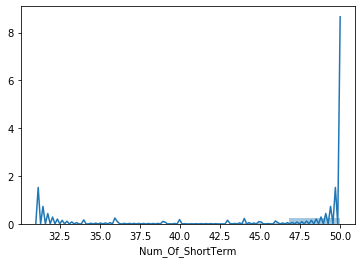

In [95]:
sns.distplot(after_cluster_wards['Num_Of_ShortTerm'])

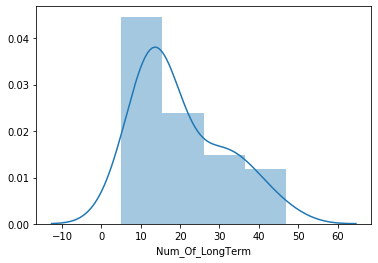

In [91]:
sns.distplot(after_cluster_wards[after_cluster_wards['k_cluster']==1]['Num_Of_LongTerm'])

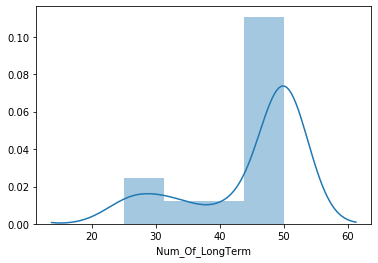

In [92]:
sns.distplot(after_cluster_wards[after_cluster_wards['k_cluster']==2]['Num_Of_LongTerm'])

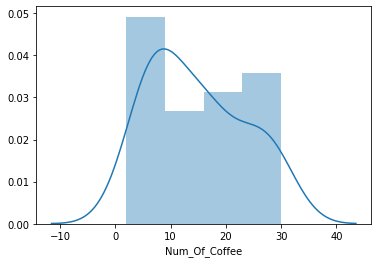

In [93]:
sns.distplot(after_cluster_wards[after_cluster_wards['k_cluster']==1]['Num_Of_Coffee'])

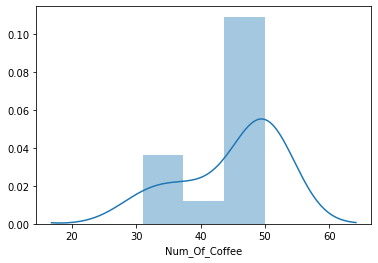

In [94]:
sns.distplot(after_cluster_wards[after_cluster_wards['k_cluster']==2]['Num_Of_Coffee'])

In [103]:
after_cluster_wards[(after_cluster_wards['k_cluster']==1) & (after_cluster_wards['Num_Of_LongTerm']>30)]

,District Code,District Name,Ward Code,Ward Name,District Population,District Acreage (Km2),District Latitude,District Longitude,Num_Of_Coffee,Num_Of_ShortTerm,Num_Of_LongTerm,k_cluster
22,777,Quận Bình Tân,27436,Phường Bình Hưng Hòa,784000,52.02,10.805543,106.603626,26,50,32,1
24,777,Quận Bình Tân,27442,Phường Bình Hưng Hoà B,784000,52.02,10.805374,106.603626,27,50,32,1
30,777,Quận Bình Tân,27460,Phường An Lạc,784000,52.02,10.728195,106.614303,17,44,39,1
32,783,Huyện Củ Chi,27496,Thị trấn Củ Chi,462000,434.77,10.974729,106.494985,21,50,38,1
37,783,Huyện Củ Chi,27532,Xã Tân An Hội,462000,434.77,10.961337,106.478210,12,50,31,1
56,785,Huyện Bình Chánh,27616,Xã Tân Kiên,705000,252.56,10.713597,106.586920,10,50,47,1
64,786,Huyện Nhà Bè,27643,Thị trấn Nhà Bè,206000,100.43,10.693761,106.739916,15,50,40,1
68,786,Huyện Nhà Bè,27655,Xã Phú Xuân,206000,100.43,10.679670,106.746324,7,50,31,1
